## Import necessary libraries

In [1]:
from src.utils import *
from src.datasets import ExcavatorDataset
from src.config import ROOT
from models.Segmentation import DeepLabV3Model, DeepLabV3PlusModel, UNetModel, PyramidAttentionNetworkModel

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device used: cuda


In [2]:
root = ROOT
train_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='train')
test_dataset = ExcavatorDataset(return_type='image+mask+path', purpose='test')

C:\workspace\similarity_metrics_of_images\src\datasets.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(value / 255.0, dtype=torch.float32)


## Load models

In [3]:
# DeepLabV3
dlv3 =DeepLabV3Model(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3_HybridFocalDiceLoss.pt')

# DeepLabV3Plus
dlv3p = DeepLabV3PlusModel(model_path=f'{ROOT}/models/torch_model_files/DeepLabV3Plus_HybridFocalDiceLoss.pt')

# UNet
unet = UNetModel(model_path=f'{ROOT}/models/torch_model_files/UNet_HybridFocalDiceLoss.pt')

# Pyramid Attention Network
pan = PyramidAttentionNetworkModel(model_path=f'{ROOT}/models/torch_model_files/PyramidAttentionNetwork_HybridFocalDiceLoss.pt')

# Pass a model to its corresponding ioU file
iou_paths = {
    dlv3: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3.h5'
    },
    dlv3p: {
        'train': f'{ROOT}/res/model_performance/train_iou_dlv3p.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_dlv3p.h5'
    },
    unet: {
        'train': f'{ROOT}/res/model_performance/train_iou_unet.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_unet.h5'
    },
    pan: {
        'train': f'{ROOT}/res/model_performance/train_iou_pan.h5',
        'val': f'{ROOT}/res/model_performance/val_iou_pan.h5'
    }
}

2024-12-25 19:53:18,250 - DeepLabV3 - INFO - Device used for model: cuda
2024-12-25 19:53:19,793 - DeepLabV3Plus - INFO - Device used for model: cuda
2024-12-25 19:53:20,230 - UNet - INFO - Device used for model: cuda
2024-12-25 19:53:20,629 - PyramidAttentionNetwork - INFO - Device used for model: cuda


## 1. First, analyze the IoU values for each model

In [4]:
iou_vals = {}

for model in iou_paths:
    iou_vals[model] = np.array(list(load_hdf5(iou_paths[model]['train']).values()))


In [5]:
for model, iou in iou_vals.items():
    print(f"Model: {model.__class__.__name__}\nMean IoU: {iou.mean()}\nMedian IoU: {np.median(iou)}\n")

Model: DeepLabV3Model
Mean IoU: 0.9376742839813232
Median IoU: 0.9393589496612549

Model: DeepLabV3PlusModel
Mean IoU: 0.8732065558433533
Median IoU: 0.8805962800979614

Model: UNetModel
Mean IoU: 0.825289249420166
Median IoU: 0.8395569324493408

Model: PyramidAttentionNetworkModel
Mean IoU: 0.8692744970321655
Median IoU: 0.8807094097137451



## Plot the IoU values for each model

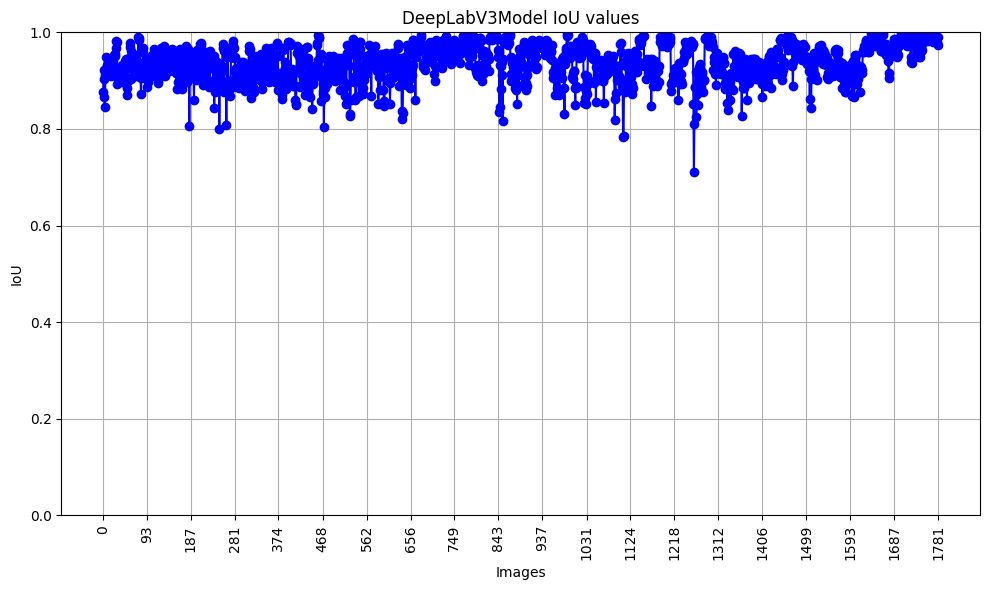

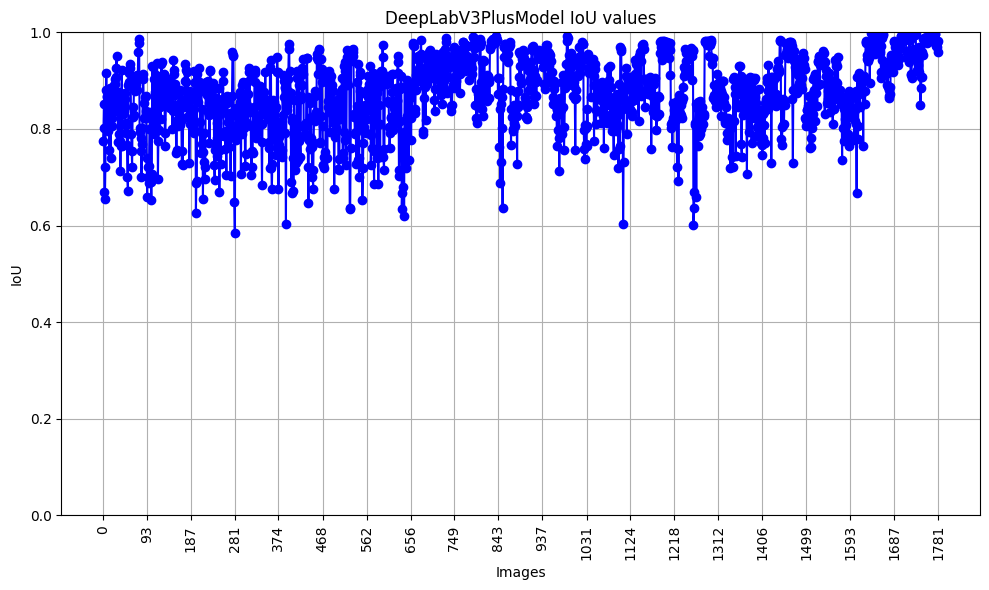

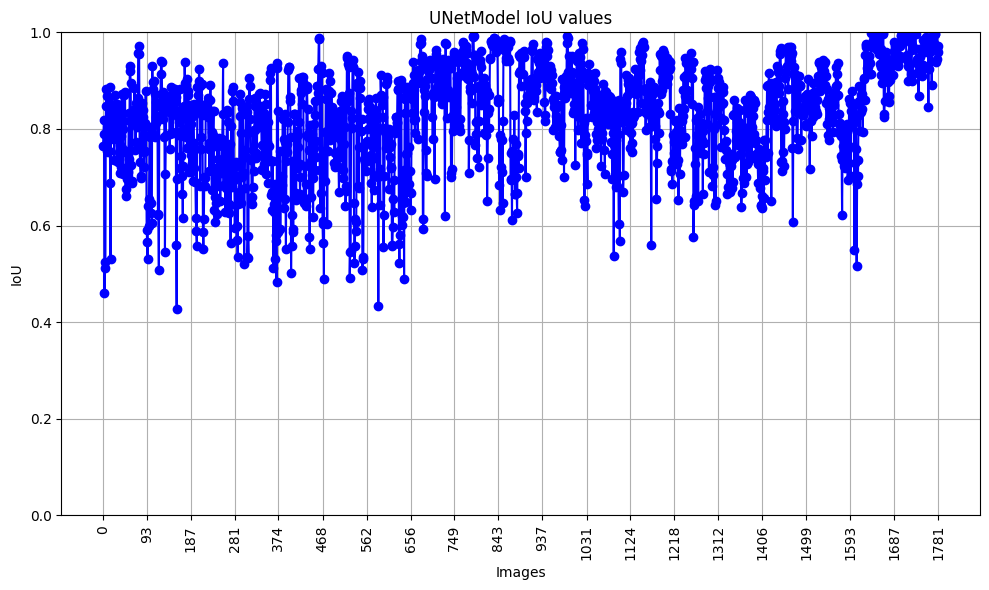

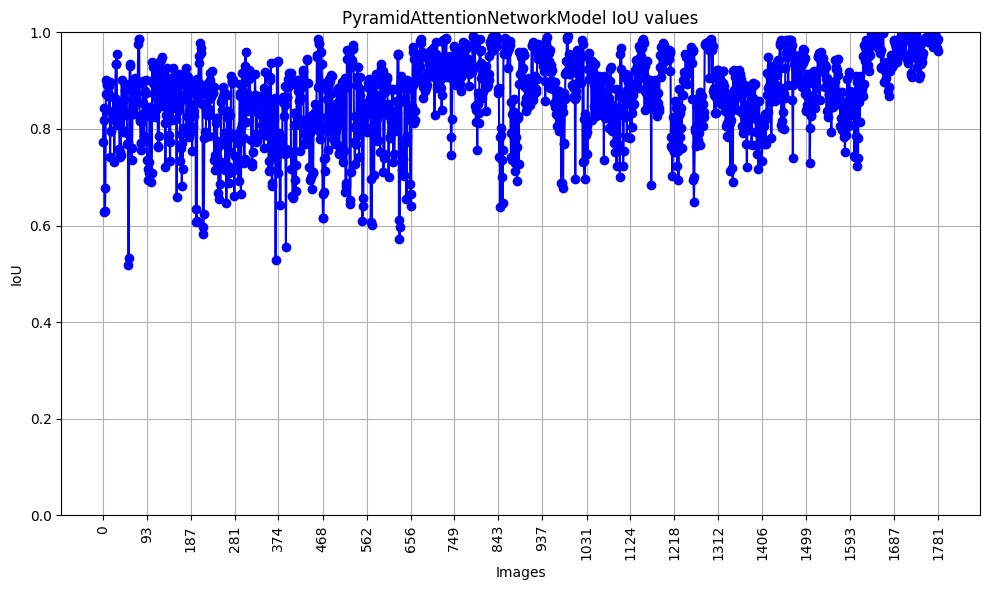

In [6]:
for model, iou in iou_vals.items():
    plot_and_save_lineplot(y=iou,
                           y_lim=(0, 1),
                            title=f'{model.__class__.__name__} IoU values',
                           sort_y=False,
                           xlabel='Images',
                            ylabel='IoU',
                            save_path=f'{ROOT}/res/model_performance/{model.__class__.__name__}_iou_values.png')

## First, Silhoutte score will be used to determine the optimal number of clusters

Silhoutte score is computed as;

$$
\frac{b - a}{\max(a, b)}
$$

where;
- $a$ is the mean distance between a sample and all other points in the same class.
- $b$ is the mean distance between a sample and all other points in the next nearest cluster.
- The score ranges from -1 to 1. A score of 1 indicates that the sample is far away from the neighboring clusters. A score of -1 indicates that the sample is close to the neighboring clusters.

In [7]:
# Load the features
# TODO: sort each model's iou values based on path to make sure they are in the correct order
iou_feat = np.vstack([iou_vals[md] for md in iou_vals.keys()]).T
print("Shape of the features:", iou_feat.shape)

Shape of the features: (1782, 4)


- k = 2 yields the highest silhouette score. Howver, this is not enough.
- Next, attempt to compute the `within-cluster sum of squares` to determine the optimal number of clusters. Then, take the elbow point as the optimal number of clusters.

For k=2, Silhouette Score = 0.49828359484672546
For k=3, Silhouette Score = 0.4369928240776062
For k=4, Silhouette Score = 0.3977980315685272
For k=5, Silhouette Score = 0.355354905128479
For k=6, Silhouette Score = 0.33355945348739624
For k=7, Silhouette Score = 0.3124510943889618
For k=8, Silhouette Score = 0.29727837443351746
For k=9, Silhouette Score = 0.2910843789577484
For k=10, Silhouette Score = 0.2670094668865204
For k=11, Silhouette Score = 0.27686113119125366
For k=12, Silhouette Score = 0.2551620900630951
For k=13, Silhouette Score = 0.25846341252326965
For k=14, Silhouette Score = 0.2614569664001465
For k=15, Silhouette Score = 0.2552810609340668
For k=16, Silhouette Score = 0.24961461126804352
For k=17, Silhouette Score = 0.2509724497795105
For k=18, Silhouette Score = 0.24524500966072083
For k=19, Silhouette Score = 0.24233178794384003
For k=20, Silhouette Score = 0.2459786981344223
For k=21, Silhouette Score = 0.24191924929618835
For k=22, Silhouette Score = 0.243125662

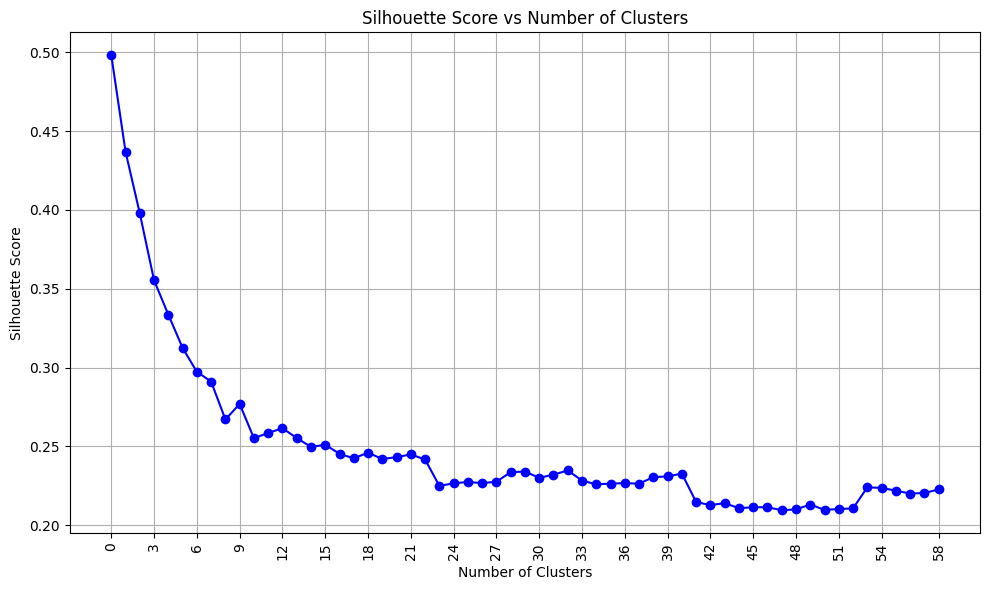

Best number of clusters: 2 with silhouette score 0.49828359484672546


2

In [8]:

# Find the optimal number of clusters
compute_optimal_clusters_silhoutte_score(iou_feat, max_clusters=60, min_clusters=4, plot=True, save_path=f'{ROOT}/res/model_performance/iou_silhoutte_score.png')


## Optimal sum of squares

For k=4, WCSS = 8.622492790222168
For k=5, WCSS = 7.307438373565674
For k=6, WCSS = 6.68925142288208
For k=7, WCSS = 6.077682971954346
For k=8, WCSS = 5.617254734039307
For k=9, WCSS = 5.34406852722168
For k=10, WCSS = 5.027047157287598
For k=11, WCSS = 4.556166648864746
For k=12, WCSS = 4.421399116516113
For k=13, WCSS = 4.215453147888184
For k=14, WCSS = 4.040990352630615
For k=15, WCSS = 3.890626907348633
For k=16, WCSS = 3.7846808433532715
For k=17, WCSS = 3.6407408714294434
For k=18, WCSS = 3.5561201572418213
For k=19, WCSS = 3.442687511444092
For k=20, WCSS = 3.2865424156188965
For k=21, WCSS = 3.223520517349243
For k=22, WCSS = 3.1245219707489014
For k=23, WCSS = 3.049288511276245
For k=24, WCSS = 2.9579007625579834
For k=25, WCSS = 2.905313491821289
For k=26, WCSS = 2.8404760360717773
For k=27, WCSS = 2.7954752445220947
For k=28, WCSS = 2.726372003555298
For k=29, WCSS = 2.653150796890259
For k=30, WCSS = 2.5971696376800537
For k=31, WCSS = 2.5457205772399902
For k=32, WCSS = 2

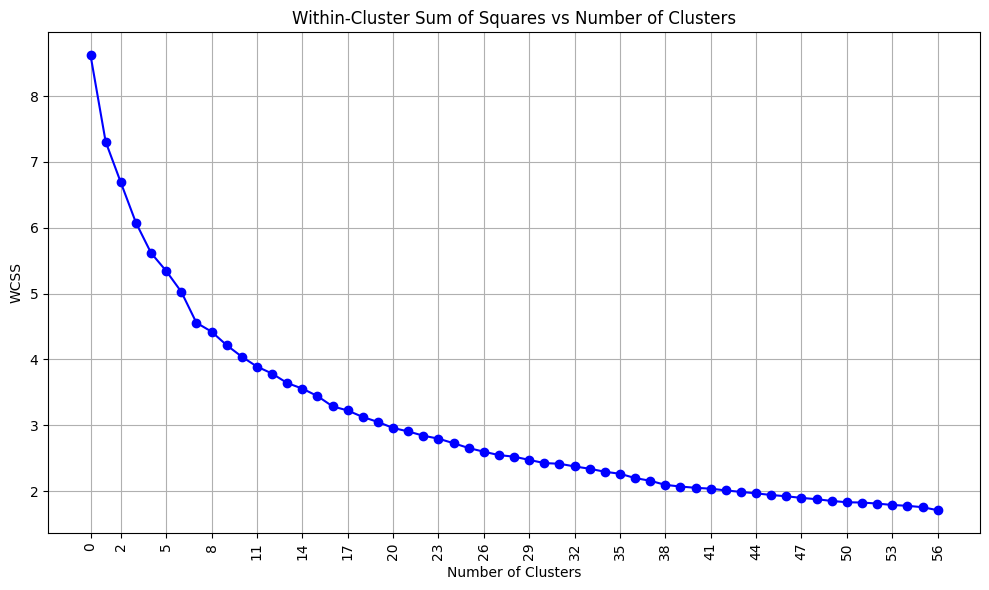

Optimal number of clusters based on elbow method: 17


np.int64(17)

In [9]:
compute_optimal_clusters_wcss(iou_feat, max_clusters=60, min_clusters=4, plot=True, save_path=f'{ROOT}/res/model_performance/iou_wcss.png')